# Loading packages

In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

# Preparing the Network

In [17]:

model = models.resnet50(weights="DEFAULT")
num_features = model.fc.in_features

model.fc = nn.Linear(in_features=num_features, out_features=2, bias=True)
nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0.0)

# The model weights are frozen except for the fully connected layer
model = model.requires_grad_(False)
model.fc.weight.requires_grad_(True)
model.fc.bias.requires_grad_(True)
pass

# Loading the data

In [18]:
generator1 = torch.Generator().manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_all = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset_all = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Filter the dataset to include only 'plane' and 'car' classes
classes_of_interest = [0, 1] # plane, automobile
trainset = [item for i, item in enumerate(trainset_all) if trainset_all.targets[i] in classes_of_interest]
test_dataset = [item for i, item in enumerate(testset_all) if testset_all.targets[i] in classes_of_interest]

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# separate train and validation sets
val_portion = 0.2
validation_size = int(val_portion*len(trainset))
train_size = len(trainset) - validation_size
train_dataset, val_dataset = random_split(trainset, [train_size, validation_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training

Epoch [1/10], Train Loss: 0.5864, Train Accuracy: 70.00%
Validation Loss: 0.6175, Validation Accuracy: 78.40%
Epoch [2/10], Train Loss: 0.4729, Train Accuracy: 78.51%
Validation Loss: 0.4863, Validation Accuracy: 81.65%
Epoch [3/10], Train Loss: 0.4451, Train Accuracy: 80.41%
Validation Loss: 0.4708, Validation Accuracy: 82.40%
Epoch [4/10], Train Loss: 0.4212, Train Accuracy: 82.08%
Validation Loss: 0.4850, Validation Accuracy: 83.85%
Epoch [5/10], Train Loss: 0.4116, Train Accuracy: 82.36%
Validation Loss: 0.3735, Validation Accuracy: 84.75%
Epoch [6/10], Train Loss: 0.4148, Train Accuracy: 82.42%
Validation Loss: 0.3623, Validation Accuracy: 85.40%
Epoch [7/10], Train Loss: 0.3952, Train Accuracy: 83.16%
Validation Loss: 0.3859, Validation Accuracy: 83.35%
Epoch [8/10], Train Loss: 0.3995, Train Accuracy: 83.28%
Validation Loss: 0.4633, Validation Accuracy: 83.85%
Epoch [9/10], Train Loss: 0.4006, Train Accuracy: 82.73%
Validation Loss: 0.3756, Validation Accuracy: 84.90%
Epoch [10/

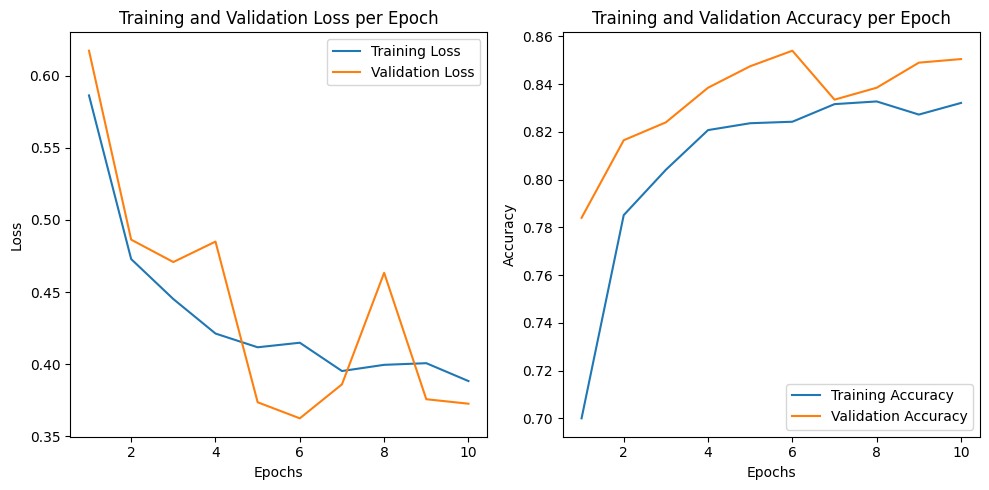

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()

epochs = 10  # Change the number of epochs as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader):

        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # print(outputs)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = correct / total

    train_loss_values.append(epoch_train_loss)
    train_accuracy_values.append(epoch_train_accuracy)

    print(f"Epoch [{epoch + 1}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_data in valloader:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    epoch_val_loss = val_running_loss / len(valloader)
    epoch_val_accuracy = val_correct / val_total

    val_loss_values.append(epoch_val_loss)
    val_accuracy_values.append(epoch_val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {100 * epoch_val_accuracy:.2f}%")

print("Finished Training")

# Calculate accuracy on test dataset
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data in testloader:
        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {100 * test_accuracy:.2f}%")


# Plotting accuracy and loss per epoch
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
torch.save(model.state_dict(), 'saved_model_state_dict.pth')

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# !mkdir '/content/drive/MyDrive/DeepHW/'
torch.save(model.state_dict(), '/content/drive/MyDrive/DeepHW/q1_model_state_dict.pth')